# Plot clone dynamics

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/pop_dyn_plot_dynamics"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

## Counts of clone barcodes

Load preprocessed data.

Preprocessing steps (previously done) consist of:
- Call library barcode.
- Error correction of clone barcode by consensus.
- Sum counts for error corrected clone barcode cluster.
- Call genuine barcodes (filtering to remove errors due to PCR and sequencing noise).

In [4]:
infile = "../preprocessed_data/pop_dyn_data/clone_barcodes.tsv.gz"

obs_raw = pd.read_csv(infile, sep="\t", header=0, index_col=None)

print(obs_raw.shape)
obs_raw.head()

(4229949, 11)


,well,library_barcode_call,clone_barcode_consensus,lib,count,time,supernatant_or_cells,call_genuine_clone_barcode_raw,call_genuine_clone_barcode_dynamics,call_genuine_clone_barcode_fidelity,n_timepoints_seen
0,puro,LB1,AGACAGTGTGACAGTGTGTGACTCTGA,sFH11-1,565,0,supernatant,True,True,False,6
1,puro,LB1,TGAGAGTGTCTGACTCAGTCTCTGTGT,sFH11-1,540,0,supernatant,True,True,False,2
2,puro,LB1,TGTCTGAGTCTGTCTGTGTCACTGTCT,sFH11-1,491,0,supernatant,True,True,False,5
3,puro,LB1,AGAGTCTGACTCACTCAGTGTCTGTCT,sFH11-1,478,0,supernatant,True,True,False,6
4,puro,LB1,ACTGTCTGTCAGACACTCTGTCACTCT,sFH11-1,461,0,supernatant,True,True,False,2


## Counts of spike-in standard for normalization

In [5]:
infile = "../preprocessed_data/pop_dyn_data/counts_spike_in_standard.tsv"

counts_STD = pd.read_csv(infile, sep="\t", index_col=None, header=None)
counts_STD.columns = ["lib", "count"]
counts_STD = counts_STD.set_index("lib")

print(counts_STD.shape)
counts_STD.head()

(27, 1)


,count
lib,
sFH11-1,7660
sFH11-2,24221
sFH11-3,29569
sFH11-4,13359
sFH11-5,2401


# Preprocess data

## Select data used for this analysis

In [6]:
# Drop replicates at final timepoint (which would complicate the analysis by double-counting)
obs_raw = obs_raw.loc[obs_raw["lib"].isin(["sFH11-7", "sFH11-14", "sFH11-21"]) == False]

# Select barcodes flagged as genuine and relevant to this analysis
obs = obs_raw.loc[obs_raw["call_genuine_clone_barcode_dynamics"] == True]

print(obs.shape)
obs.head()

(38669, 11)


,well,library_barcode_call,clone_barcode_consensus,lib,count,time,supernatant_or_cells,call_genuine_clone_barcode_raw,call_genuine_clone_barcode_dynamics,call_genuine_clone_barcode_fidelity,n_timepoints_seen
0,puro,LB1,AGACAGTGTGACAGTGTGTGACTCTGA,sFH11-1,565,0,supernatant,True,True,False,6
1,puro,LB1,TGAGAGTGTCTGACTCAGTCTCTGTGT,sFH11-1,540,0,supernatant,True,True,False,2
2,puro,LB1,TGTCTGAGTCTGTCTGTGTCACTGTCT,sFH11-1,491,0,supernatant,True,True,False,5
3,puro,LB1,AGAGTCTGACTCACTCAGTGTCTGTCT,sFH11-1,478,0,supernatant,True,True,False,6
4,puro,LB1,ACTGTCTGTCAGACACTCTGTCACTCT,sFH11-1,461,0,supernatant,True,True,False,2


## Fill unobserved counts with zero

In [7]:
%%time

# Construct new dataframe which has a row for every clone and time

obs_full = pd.DataFrame(columns=obs.columns)

for (well, library_barcode_call), group in obs.groupby(["well", "library_barcode_call"]):
    
    # Create index from cross product of well, library_barcode, time, and clone_barcodes for this group
    index = pd.MultiIndex.from_product([obs.well.unique(),
                                        obs.library_barcode_call.unique(),
                                        obs.time.unique(),
                                        group["clone_barcode_consensus"].unique()],
                                       names=["well", "library_barcode_call", "time", "clone_barcode_consensus"])
    
    df_temp = pd.DataFrame(index=index).reset_index()
    obs_full = obs_full.append(df_temp)
    
    obs_full = obs_full.drop_duplicates()  # not sure why duplicate rows are created, but we drop them

obs_full["count"] = 0  # set default count to zero (for unobserved rows)

# Copy values from rows with data
obs_full = obs_full.set_index(["well", "library_barcode_call", "clone_barcode_consensus", "time"])
obs_temp = obs.set_index(["well", "library_barcode_call", "clone_barcode_consensus", "time"])
obs_full.loc[obs_temp.index] = obs_temp

obs_full = obs_full.reset_index()

# Sort index
obs_full = obs_full.sort_index()

# Propagate sequencing library name to rows (required for normalization)

obs_full = obs_full.set_index(["well", "time"])

for (well, time), group in obs.groupby(["well", "time"]):
    assert len(group["lib"].unique()) == 1  # there should only be one lib per well and timepoint
    lib_temp = group["lib"].unique()[0]
    obs_full.loc[(well, time), "lib"] = lib_temp

obs_full = obs_full.reset_index()

# Propagate values for observed rows to rows of new dataframe

obs_full = obs_full.set_index(["well", "library_barcode_call", "clone_barcode_consensus"])

for (well, library_barcode_call, clone_barcode_consensus), group in obs.groupby(["well", "library_barcode_call", "clone_barcode_consensus"]):
    assert len(group["n_timepoints_seen"].unique()) == 1  # there should only be one unique value for number of timepoints seen
    obs_full.loc[(well, library_barcode_call, clone_barcode_consensus), "n_timepoints_seen"] = group["n_timepoints_seen"].unique()[0]

obs_full = obs_full.reset_index()

# Examine dataframe
print(obs_full.shape)
obs_full.head()

# Note that flags and n_timepoints_seen are not propagated. Be careful when using these in obs_full.

/scratch/resources/anaconda3/envs/RNA_export_magic/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)
/scratch/resources/anaconda3/envs/RNA_export_magic/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2472: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = fn(*args, **kwargs)


(526536, 11)
CPU times: user 2min 57s, sys: 692 ms, total: 2min 58s
Wall time: 2min 58s


,well,library_barcode_call,clone_barcode_consensus,time,lib,count,supernatant_or_cells,call_genuine_clone_barcode_raw,call_genuine_clone_barcode_dynamics,call_genuine_clone_barcode_fidelity,n_timepoints_seen
0,puro,LB1,AGTCACTGTGTGACACTGTGACAGAGA,0,sFH11-1,0,NaN,NaN,NaN,NaN,NaN
1,puro,LB1,AGAGTGTGTGTGAGTGACTCAGAGTGT,0,sFH11-1,0,NaN,NaN,NaN,NaN,NaN
2,puro,LB1,TGTCAGACTGTCTGAGTGTCTCTGAGT,0,sFH11-1,0,NaN,NaN,NaN,NaN,NaN
3,puro,LB1,TGACACACTGTCTGTCACAGACACAGA,0,sFH11-1,0,NaN,NaN,NaN,NaN,NaN
4,puro,LB1,TCAGTGAGTGTCACTCAGTCAGTCTGA,0,sFH11-1,0,NaN,NaN,NaN,NaN,NaN


## Normalize abundances using spike-in standard

In [8]:
# Normalization yields counts per million of spike-in standard (CPMS)

# Calculate normalization factor by summing counts of standard
counts_STD["norm_factor_cpm_std"] = 1e6/counts_STD["count"]

# Calculate counts per million of standard
obs["cpm_std"] = np.array(obs["count"]) * np.array(counts_STD["norm_factor_cpm_std"].loc[obs["lib"]])

# Analogous calculation for zero-filled dataframe containing zeros for missing values
obs_full["cpm_std"] = np.array(obs_full["count"]) * np.array(counts_STD["norm_factor_cpm_std"].loc[obs_full["lib"]])

/scratch/resources/anaconda3/envs/RNA_export_magic/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


# Set plot parameters

In [9]:
# Set colors
palette = ["#9e9ac8", "#74c476"]

# Plot dynamics under puromycin selection

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


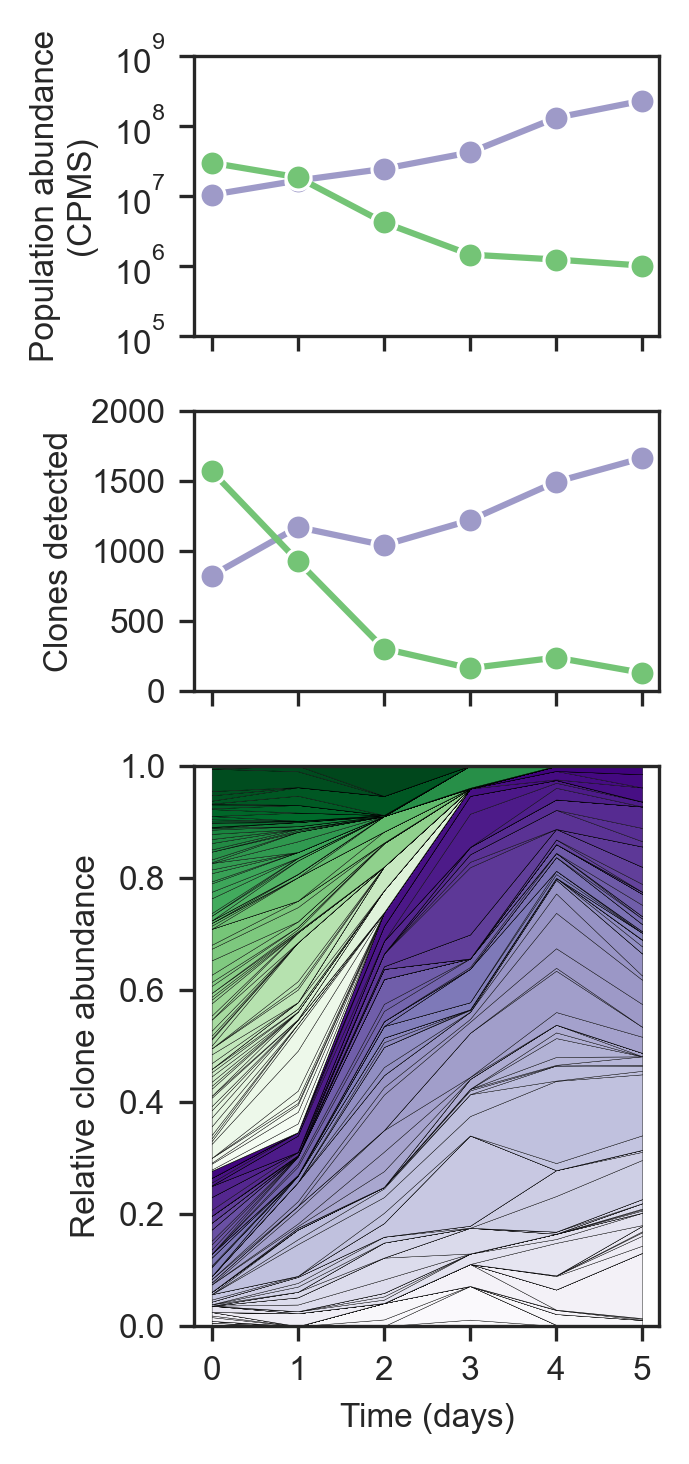

In [10]:
random_state = 0
well = "puro"
n_clones_sample = 100

##### Frequency

### Population 1
# Select data
selector = (obs_full["n_timepoints_seen"] >= 1) & (obs_full["well"] == well) & (obs_full["library_barcode_call"] == "LB1")
data1 = obs_full.loc[selector]

# Sample clones
clone_barcodes_sampled = pd.Series(data1["clone_barcode_consensus"].unique()).sample(n=n_clones_sample, random_state=random_state)
data1 = data1.set_index("clone_barcode_consensus").loc[clone_barcodes_sampled].reset_index()

# Pivot table 
data_pivot1 = data1.pivot(index=["clone_barcode_consensus"], columns="time", values="cpm_std")


### Population 2
# Select data
selector = (obs_full["n_timepoints_seen"] >= 1) & (obs_full["well"] == well) & (obs_full["library_barcode_call"] == "LB2")
data2 = obs_full.loc[selector]

# Sample clones
clone_barcodes_sampled = pd.Series(data2["clone_barcode_consensus"].unique()).sample(n=n_clones_sample, random_state=random_state)
data2 = data2.set_index("clone_barcode_consensus").loc[clone_barcodes_sampled].reset_index()

# Pivot table 
data_pivot2 = data2.pivot(index=["clone_barcode_consensus"], columns="time", values="cpm_std")

### Concatenate data
data_concat = pd.concat([data_pivot1, data_pivot2])

### Normalize to sum at each timepoint
data_norm = data_concat / data_concat.sum(axis=0)

# Set colors
colors1 = sns.color_palette("Purples", data_pivot1.shape[0])
colors2 = sns.color_palette("Greens", data_pivot2.shape[0])
colors_concat = colors1 + colors2

##### Plot

fig, axes = plt.subplots(3, 1, figsize=(2,5.5), sharex=True, gridspec_kw={"height_ratios": [2,2,4]})

##### Total abundance

ax = axes[0]

selector = (obs["well"] == well) & (obs["library_barcode_call"] == "LB1")
data = obs.loc[selector].groupby("time")["cpm_std"].sum().reset_index()
sns.lineplot(ax=ax, data=data, x="time", y="cpm_std", color=palette[0], label="Puro resistant", legend=False, marker="o")

selector = (obs["well"] == well) & (obs["library_barcode_call"] == "LB2")
data = obs.loc[selector].groupby("time")["cpm_std"].sum().reset_index()
sns.lineplot(ax=ax, data=data, x="time", y="cpm_std", color=palette[1], label="Zeo resistant", legend=False, marker="o")

ax.set_yscale("log")
ax.set_ylim(1e5, 1e9)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_yticks([1e5, 1e6, 1e7, 1e8, 1e9])
# ax.set_xticks([0, 1, 2, 3, 4, 5])

ax.set_ylabel("Population abundance\n(CPMS)")
# ax.set_xlabel("Time (days)")

# fig.legend(loc="center left", bbox_to_anchor=(0.92, 0.8), title="Population")

##### Clones detected

ax = axes[1]

selector = (obs["well"] == well) & (obs["library_barcode_call"] == "LB1")
data = obs.loc[selector].groupby("time")["clone_barcode_consensus"].nunique().reset_index()
data = data.rename({"clone_barcode_consensus": "n_unique_clone_barcode_consensus"}, axis=1)
sns.lineplot(ax=ax, data=data, x="time", y="n_unique_clone_barcode_consensus", color=palette[0], label="Puro resistant", legend=False, marker="o")

selector = (obs["well"] == well) & (obs["library_barcode_call"] == "LB2")
data = obs.loc[selector].groupby("time")["clone_barcode_consensus"].nunique().reset_index()
data = data.rename({"clone_barcode_consensus": "n_unique_clone_barcode_consensus"}, axis=1)
sns.lineplot(ax=ax, data=data, x="time", y="n_unique_clone_barcode_consensus", color=palette[1], label="Zeo resistant", legend=False, marker="o")

# ax.set_yscale("log")
ax.set_ylim(0, 2000)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_yticks([0, 500, 1000, 1500, 2000])

ax.set_ylabel("Clones detected")

##### Plot frequency

ax = axes[2]
ax.stackplot(np.array(data_norm.columns),
             np.array(data_norm),
             linewidth=0.1,
             edgecolor="k",
             colors=colors_concat)

ax.set_xlim(-0.2,5.2)
ax.set_ylim(0,1)

ax.set_xlabel("Time (days)")
ax.set_ylabel("Relative clone abundance")

ax.set_xticks([0, 1, 2, 3, 4, 5])

# # Turn off labels
# for ax in axes:
#     ax.set_xlabel("")
#     ax.set_ylabel("")

save_figure(fig, "pop_dyn_subplots_abundance_clones_stream_puro")

# Plot dynamics under zeocin selection

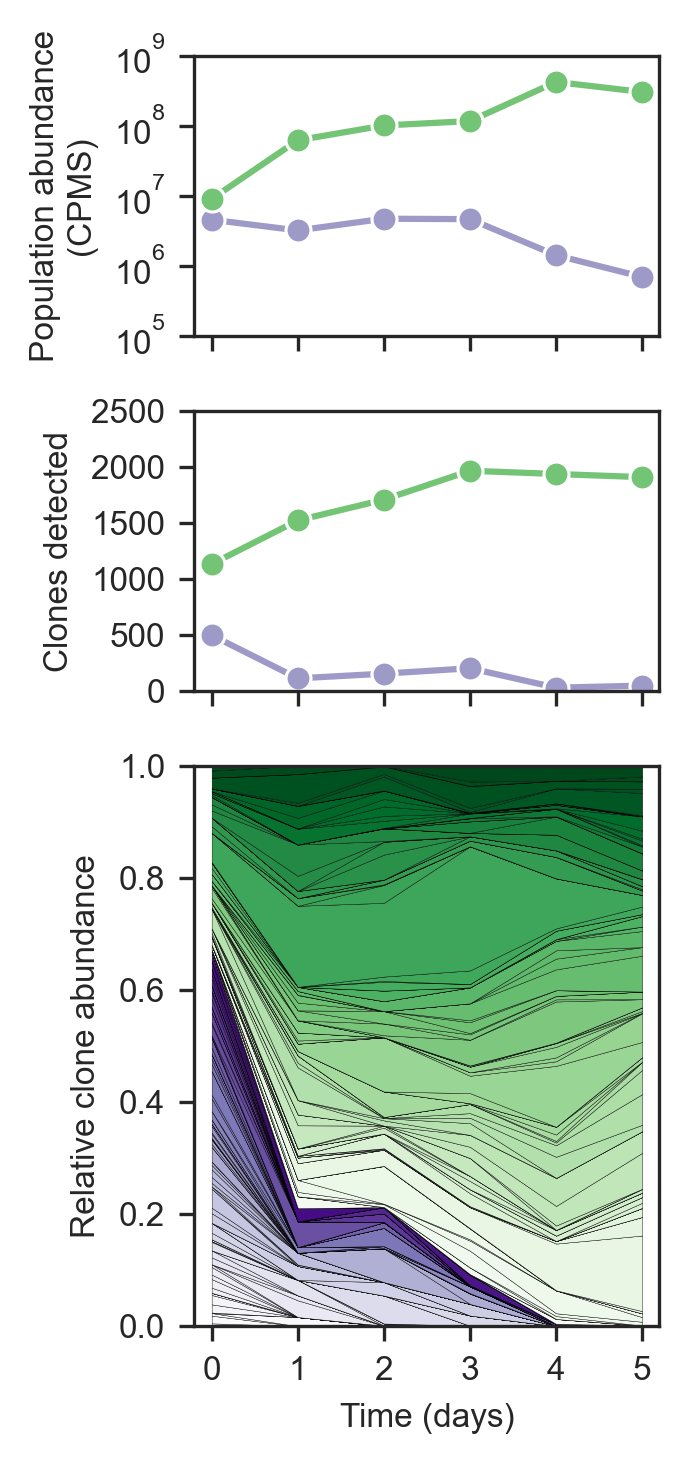

In [11]:
random_state = 0
well = "zeo"
n_clones_sample = 100

##### Frequency

### Population 1
# Select data
selector = (obs_full["n_timepoints_seen"] >= 1) & (obs_full["well"] == well) & (obs_full["library_barcode_call"] == "LB1")
data1 = obs_full.loc[selector]

# Sample clones
clone_barcodes_sampled = pd.Series(data1["clone_barcode_consensus"].unique()).sample(n=n_clones_sample, random_state=random_state)
data1 = data1.set_index("clone_barcode_consensus").loc[clone_barcodes_sampled].reset_index()

# Pivot table 
data_pivot1 = data1.pivot(index=["clone_barcode_consensus"], columns="time", values="cpm_std")


### Population 2
# Select data
selector = (obs_full["n_timepoints_seen"] >= 1) & (obs_full["well"] == well) & (obs_full["library_barcode_call"] == "LB2")
data2 = obs_full.loc[selector]

# Sample clones
clone_barcodes_sampled = pd.Series(data2["clone_barcode_consensus"].unique()).sample(n=n_clones_sample, random_state=random_state)
data2 = data2.set_index("clone_barcode_consensus").loc[clone_barcodes_sampled].reset_index()

# Pivot table 
data_pivot2 = data2.pivot(index=["clone_barcode_consensus"], columns="time", values="cpm_std")

### Concatenate data
data_concat = pd.concat([data_pivot1, data_pivot2])

### Normalize to sum at each timepoint
data_norm = data_concat / data_concat.sum(axis=0)

# Set colors
colors1 = sns.color_palette("Purples", data_pivot1.shape[0])
colors2 = sns.color_palette("Greens", data_pivot2.shape[0])
colors_concat = colors1 + colors2

##### Plot

fig, axes = plt.subplots(3, 1, figsize=(2,5.5), sharex=True, gridspec_kw={"height_ratios": [2,2,4]})

##### Total abundance

ax = axes[0]

selector = (obs["well"] == well) & (obs["library_barcode_call"] == "LB1")
data = obs.loc[selector].groupby("time")["cpm_std"].sum().reset_index()
sns.lineplot(ax=ax, data=data, x="time", y="cpm_std", color=palette[0], label="Puro resistant", legend=False, marker="o")

selector = (obs["well"] == well) & (obs["library_barcode_call"] == "LB2")
data = obs.loc[selector].groupby("time")["cpm_std"].sum().reset_index()
sns.lineplot(ax=ax, data=data, x="time", y="cpm_std", color=palette[1], label="Zeo resistant", legend=False, marker="o")

ax.set_yscale("log")
ax.set_ylim(1e5, 1e9)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_yticks([1e5, 1e6, 1e7, 1e8, 1e9])
# ax.set_xticks([0, 1, 2, 3, 4, 5])

ax.set_ylabel("Population abundance\n(CPMS)")
# ax.set_xlabel("Time (days)")

# fig.legend(loc="center left", bbox_to_anchor=(0.92, 0.8), title="Population")

##### Clones detected

ax = axes[1]

selector = (obs["well"] == well) & (obs["library_barcode_call"] == "LB1")
data = obs.loc[selector].groupby("time")["clone_barcode_consensus"].nunique().reset_index()
data = data.rename({"clone_barcode_consensus": "n_unique_clone_barcode_consensus"}, axis=1)
sns.lineplot(ax=ax, data=data, x="time", y="n_unique_clone_barcode_consensus", color=palette[0], label="Puro resistant", legend=False, marker="o")

selector = (obs["well"] == well) & (obs["library_barcode_call"] == "LB2")
data = obs.loc[selector].groupby("time")["clone_barcode_consensus"].nunique().reset_index()
data = data.rename({"clone_barcode_consensus": "n_unique_clone_barcode_consensus"}, axis=1)
sns.lineplot(ax=ax, data=data, x="time", y="n_unique_clone_barcode_consensus", color=palette[1], label="Zeo resistant", legend=False, marker="o")

# ax.set_yscale("log")
ax.set_ylim(0, 2500)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_yticks([0, 500, 1000, 1500, 2000, 2500])

ax.set_ylabel("Clones detected")

##### Plot frequency

ax = axes[2]
ax.stackplot(np.array(data_norm.columns),
             np.array(data_norm),
             linewidth=0.1,
             edgecolor="k",
             colors=colors_concat)

ax.set_xlim(-0.2,5.2)
ax.set_ylim(0,1)

ax.set_xlabel("Time (days)")
ax.set_ylabel("Relative clone abundance")

ax.set_xticks([0, 1, 2, 3, 4, 5])

# # Turn off labels
# for ax in axes:
#     ax.set_xlabel("")
#     ax.set_ylabel("")

save_figure(fig, "pop_dyn_subplots_abundance_clones_stream_zeo")

# Plot dynamics without drug

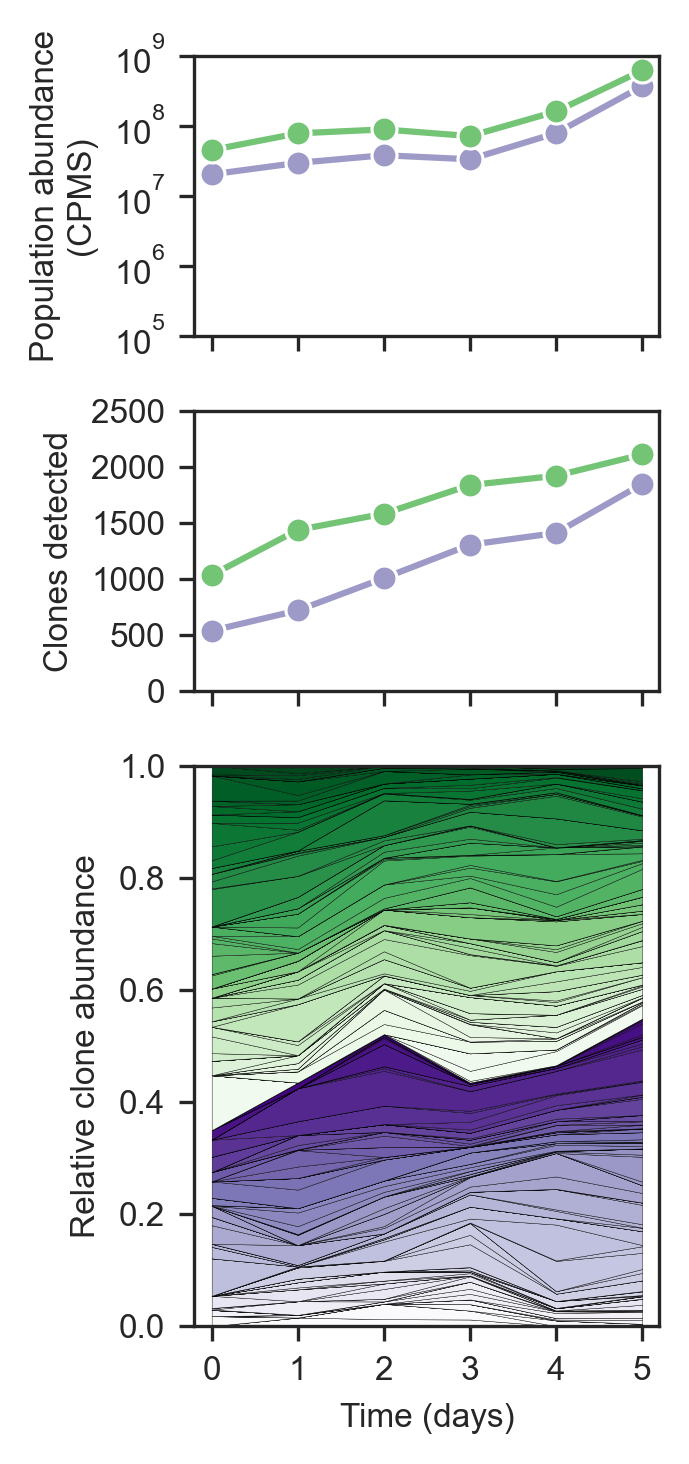

In [12]:
random_state = 0
well = "no_drug"
n_clones_sample = 100

##### Frequency

### Population 1
# Select data
selector = (obs_full["n_timepoints_seen"] >= 1) & (obs_full["well"] == well) & (obs_full["library_barcode_call"] == "LB1")
data1 = obs_full.loc[selector]

# Sample clones
clone_barcodes_sampled = pd.Series(data1["clone_barcode_consensus"].unique()).sample(n=n_clones_sample, random_state=random_state)
data1 = data1.set_index("clone_barcode_consensus").loc[clone_barcodes_sampled].reset_index()

# Pivot table 
data_pivot1 = data1.pivot(index=["clone_barcode_consensus"], columns="time", values="cpm_std")


### Population 2
# Select data
selector = (obs_full["n_timepoints_seen"] >= 1) & (obs_full["well"] == well) & (obs_full["library_barcode_call"] == "LB2")
data2 = obs_full.loc[selector]

# Sample clones
clone_barcodes_sampled = pd.Series(data2["clone_barcode_consensus"].unique()).sample(n=n_clones_sample, random_state=random_state)
data2 = data2.set_index("clone_barcode_consensus").loc[clone_barcodes_sampled].reset_index()

# Pivot table 
data_pivot2 = data2.pivot(index=["clone_barcode_consensus"], columns="time", values="cpm_std")

### Concatenate data
data_concat = pd.concat([data_pivot1, data_pivot2])

### Normalize to sum at each timepoint
data_norm = data_concat / data_concat.sum(axis=0)

# Set colors
colors1 = sns.color_palette("Purples", data_pivot1.shape[0])
colors2 = sns.color_palette("Greens", data_pivot2.shape[0])
colors_concat = colors1 + colors2

##### Plot

fig, axes = plt.subplots(3, 1, figsize=(2,5.5), sharex=True, gridspec_kw={"height_ratios": [2,2,4]})

##### Total abundance

ax = axes[0]

selector = (obs["well"] == well) & (obs["library_barcode_call"] == "LB1")
data = obs.loc[selector].groupby("time")["cpm_std"].sum().reset_index()
sns.lineplot(ax=ax, data=data, x="time", y="cpm_std", color=palette[0], label="Puro resistant", legend=False, marker="o")

selector = (obs["well"] == well) & (obs["library_barcode_call"] == "LB2")
data = obs.loc[selector].groupby("time")["cpm_std"].sum().reset_index()
sns.lineplot(ax=ax, data=data, x="time", y="cpm_std", color=palette[1], label="Zeo resistant", legend=False, marker="o")

ax.set_yscale("log")
ax.set_ylim(1e5, 1e9)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_yticks([1e5, 1e6, 1e7, 1e8, 1e9])
# ax.set_xticks([0, 1, 2, 3, 4, 5])

ax.set_ylabel("Population abundance\n(CPMS)")
# ax.set_xlabel("Time (days)")

# fig.legend(loc="center left", bbox_to_anchor=(0.92, 0.8), title="Population")

##### Clones detected

ax = axes[1]

selector = (obs["well"] == well) & (obs["library_barcode_call"] == "LB1")
data = obs.loc[selector].groupby("time")["clone_barcode_consensus"].nunique().reset_index()
data = data.rename({"clone_barcode_consensus": "n_unique_clone_barcode_consensus"}, axis=1)
sns.lineplot(ax=ax, data=data, x="time", y="n_unique_clone_barcode_consensus", color=palette[0], label="Puro resistant", legend=False, marker="o")

selector = (obs["well"] == well) & (obs["library_barcode_call"] == "LB2")
data = obs.loc[selector].groupby("time")["clone_barcode_consensus"].nunique().reset_index()
data = data.rename({"clone_barcode_consensus": "n_unique_clone_barcode_consensus"}, axis=1)
sns.lineplot(ax=ax, data=data, x="time", y="n_unique_clone_barcode_consensus", color=palette[1], label="Zeo resistant", legend=False, marker="o")

# ax.set_yscale("log")
ax.set_ylim(0, 2500)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_yticks([0, 500, 1000, 1500, 2000, 2500])

ax.set_ylabel("Clones detected")

##### Plot frequency

ax = axes[2]
ax.stackplot(np.array(data_norm.columns),
             np.array(data_norm),
             linewidth=0.1,
             edgecolor="k",
             colors=colors_concat)

ax.set_xlim(-0.2,5.2)
ax.set_ylim(0,1)

ax.set_xlabel("Time (days)")
ax.set_ylabel("Relative clone abundance")

ax.set_xticks([0, 1, 2, 3, 4, 5])

# # Turn off labels
# for ax in axes:
#     ax.set_xlabel("")
#     ax.set_ylabel("")

save_figure(fig, "pop_dyn_subplots_abundance_clones_stream_no_drug")